## Felzenszwalb and Huttenlocher 

[Efficient graph-based image segmentation, Felzenszwalb, P.F. and Huttenlocher, D.P. International Journal of Computer Vision, 2004](https://link.springer.com/article/10.1023/B:VISI.0000022288.19776.77)

Given an undirected graph $G = (V, E)$, with each edge $(v_i, v_j)$ having the corresponding weight $w(v_i, v_j)$ that corresponds to the distance btween the two nodes, we want to generate a degmentatio $S$ in which each component corresponds to a connected region of the graph $G' = (V, E')$, $E' \subseteq E$. In general, edges in connected regions have smaller weights and edges between different components have bigger weights. 

To determine if there is a boundary between two components $C_1$ and $C_2$ we use the predicate $D$. It compares inter-component differences with intra-component differences.

The internal difference is: 
$$ Int(C) = \max_{e \in MST(C, E)}w(e)$$
With MST designationg the Minimum spanning treee of the component

The difference between to components is: 
$$Dif(C_1, C_2) = \min_{v_i \in C_1, v_j \in C_2,(v_i,v_j)\in E}w(v_i, v_j)$$
If there is no edge connecting the components, $Dif(C_1, C_2) = \infty$.

$ D(C_1),(C_2) = $
- true   if $Dif(C_1, C_2) > MInt(C_1, C_2)$
- false  otherwise

With 

$$ MInt(C_1, C_2) = \min(Int(C_1) + \tau(C_1), Int(C_2) + \tau(C_2)) $$

And, 
$$\tau(C) = \frac{k}{|C|}$$
Where $k$ sets a scale of observation, in practice (and is actually called *scale* in skimage). However it is not a minimum component size.


In [3]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

### skimage implementation

In [4]:
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.data import coffee, astronaut
from skimage.util import img_as_float

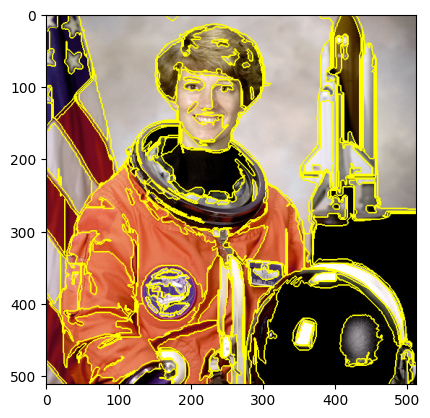

In [5]:
img = astronaut()
segments = felzenszwalb(img, scale=300, sigma=0.8, min_size=50)
plt.imshow(mark_boundaries(img, segments))

### Differentiable version with pytorch...

Based on [skimage's implementation](https://github.com/scikit-image/scikit-image/blob/main/skimage/segmentation/_felzenszwalb_cy.pyx).

In [6]:
import torch

tensor([[[0.6039, 0.5765, 0.5922],
         [0.4275, 0.4039, 0.4863],
         [0.2471, 0.2275, 0.4000],
         ...,
         [0.4980, 0.4706, 0.4510],
         [0.4706, 0.4588, 0.4157],
         [0.4902, 0.4667, 0.4314]],

        [[0.6941, 0.6706, 0.6706],
         [0.5647, 0.5529, 0.5608],
         [0.4431, 0.4471, 0.4863],
         ...,
         [0.4980, 0.4627, 0.4392],
         [0.4863, 0.4510, 0.4235],
         [0.4745, 0.4549, 0.4118]],

        [[0.7882, 0.7608, 0.7569],
         [0.7137, 0.6980, 0.6863],
         [0.6588, 0.6471, 0.6431],
         ...,
         [0.5020, 0.4706, 0.4588],
         [0.4941, 0.4549, 0.4392],
         [0.4863, 0.4471, 0.4275]],

        ...,

        [[0.7294, 0.6667, 0.6902],
         [0.7294, 0.6667, 0.6941],
         [0.7176, 0.6588, 0.6667],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039],
         [0.0000, 0.0000, 0.0000]],

        [[0.7176, 0.6627, 0.6667],
         [0.7137, 0.6549, 0.6706],
         [0.

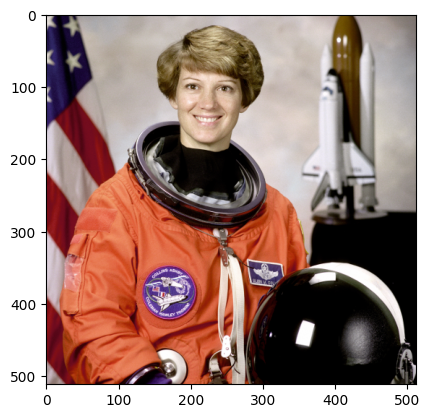

In [7]:
img_tensor = torch.tensor(img_as_float(img), requires_grad=True)
with torch.no_grad():
    plt.imshow(img_tensor.detach().numpy())
img_tensor


Computing edge weights w/ 8 connectivity

In [8]:
height, width = img_tensor.shape[:2]

down_cost   = torch.sqrt(torch.sum((img_tensor[1:, :, :] - img_tensor[:height-1, :, :]) ** 2, dim=-1))
right_cost  = torch.sqrt(torch.sum((img_tensor[:, 1:, :] - img_tensor[:, :width-1, :]) ** 2, dim=-1))
# dright_cost = torch.sqrt(torch.sum((img_tensor[1:, 1:, :] - img_tensor[:height-1, :width-1, :]) ** 2, dim=-1))
# uright_cost = torch.sqrt(torch.sum((img_tensor[1:, :width-1, :] - img_tensor[:height-1, 1:, :]) ** 2, dim=-1))
# costs = torch.hstack([right_cost.ravel(), down_cost.ravel(), dright_cost.ravel(), uright_cost.ravel()])
costs = torch.hstack([right_cost.ravel(), down_cost.ravel()])

In [9]:
print(costs)
print(costs.shape)

tensor([0.2686, 0.2667, 0.0474,  ..., 0.0039, 0.0000, 0.0000],
       dtype=torch.float64, grad_fn=<CatBackward0>)
torch.Size([523264])


Computing the graphs edges $E$ and $S_0$ 

In [10]:
S = torch.arange(width * height).reshape(width, height)
S

tensor([[     0,      1,      2,  ...,    509,    510,    511],
        [   512,    513,    514,  ...,   1021,   1022,   1023],
        [  1024,   1025,   1026,  ...,   1533,   1534,   1535],
        ...,
        [260608, 260609, 260610,  ..., 261117, 261118, 261119],
        [261120, 261121, 261122,  ..., 261629, 261630, 261631],
        [261632, 261633, 261634,  ..., 262141, 262142, 262143]])

In [11]:
down_edges   = torch.column_stack((S[1:, :].ravel(), S[:height-1, :].ravel()))
right_edges  = torch.column_stack((S[:, 1:].ravel(), S[:, :width-1].ravel()))
# dright_edges = torch.column_stack((S[1:, 1:].ravel(), S[:height-1, :width-1].ravel()))
# uright_edges = torch.column_stack((S[:height-1, 1:].ravel(), S[1:, :width-1].ravel()))
# edges = torch.vstack((right_edges, down_edges, dright_edges, uright_edges))
edges = torch.vstack((right_edges, down_edges))
edges

tensor([[     1,      0],
        [     2,      1],
        [     3,      2],
        ...,
        [262141, 261629],
        [262142, 261630],
        [262143, 261631]])

In [12]:
edge_queue = torch.argsort(costs)
edge_queue
edges = edges[edge_queue]
costs = costs[edge_queue]
segment_size = torch.ones(width * height, dtype=torch.int8)

In [13]:
Int = torch.zeros(width * height) # Internal differences 
Int

tensor([0., 0., 0.,  ..., 0., 0., 0.])

#### Issue: How to do the set operations?

1. Sparse matrices

$S$ will be a $(H*W) \times (H*W)$ matrix. Basically the same idea as a sparse edge matrix. dim = 1 represents the segments $C$, dim = 0 the nodes $V$ that compose the segment.

In [14]:
indices = np.array([np.arange(width*height), np.arange(width*height)], dtype=np.int64)
values  = np.ones(width * height)
print(indices, values)

Ss = torch.sparse_coo_tensor(indices, values, (width*height, width*height), requires_grad=True)
Ss

[[     0      1      2 ... 262141 262142 262143]
 [     0      1      2 ... 262141 262142 262143]] [1. 1. 1. ... 1. 1. 1.]


tensor(indices=tensor([[     0,      1,      2,  ..., 262141, 262142, 262143],
                       [     0,      1,      2,  ..., 262141, 262142, 262143]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(262144, 262144), nnz=262144, dtype=torch.float64,
       layout=torch.sparse_coo, requires_grad=True)

Merge operation of segments $C_i$ and $C_j$ into $C_i$:
1. Select the vector $c_j$ that corresponds to $S[j, :]$
2. $c_i = c_i + c_j$
3. $c_j = c_j - c_j$

In [15]:
ci_idx, cj_idx = 0, 2
off_idx = ci_idx - cj_idx

cj = torch.select(Ss, 1, cj_idx).coalesce()

cj_indices = cj.indices()
top = torch.concat([torch.ones_like(cj_indices).flatten() * ci_idx, torch.ones_like(cj_indices).flatten() * cj_idx])
bottom = torch.concat([cj_indices.flatten(), cj_indices.flatten()])
indices = torch.stack([bottom, top])

cj_values = cj.values()
values = torch.concat([cj_values, -1 * cj_values])
print(values)

off = torch.sparse_coo_tensor(indices, values, (width*height, width*height))
print(off)

Ss = Ss + off
Ss = Ss.coalesce()
Ss

tensor([ 1., -1.], dtype=torch.float64, grad_fn=<CatBackward0>)
tensor(indices=tensor([[2, 2],
                       [0, 2]]),
       values=tensor([ 1., -1.]),
       size=(262144, 262144), nnz=2, dtype=torch.float64,
       layout=torch.sparse_coo,
       grad_fn=<SparseCooTensorWithDimsAndTensorsBackward0>)


tensor(indices=tensor([[     0,      1,      2,  ..., 262141, 262142, 262143],
                       [     0,      1,      0,  ..., 262141, 262142, 262143]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(262144, 262144), nnz=262145, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)

In [136]:
Ss.size()

torch.Size([262144, 262144])

In [16]:
def merge_segments(ci, cj, Ss):
    cj_segment = torch.select(Ss, 1, cj).coalesce()

    cj_indices = cj_segment.indices().flatten()
    indices_v = torch.concat([cj_indices, cj_indices]) # nodes
    indices_c = torch.concat([ci * torch.ones_like(cj_indices), cj * torch.ones_like(cj_indices)]) # segments
    indices = torch.stack([indices_v, indices_c])

    cj_values = cj_segment.values()
    values = torch.concat([cj_values, -1*cj_values])

    offset = torch.sparse_coo_tensor(indices, values, Ss.size())
    return Ss + offset 

Finding the segment $C_i$ of the node $v_i$

In [17]:
vi_idx = 1
vi = torch.select(Ss, 0, vi_idx)
print(vi)
vi = vi.coalesce()
ci = torch.argmin(vi.indices().flatten())
ci

tensor(indices=tensor([[1]]),
       values=tensor([1.]),
       size=(262144,), nnz=1, dtype=torch.float64, layout=torch.sparse_coo,
       grad_fn=<SelectBackward0>)


tensor(0)

In [18]:
indices = Ss.coalesce().indices()
vi = 2
vi_indices = indices[1, torch.argwhere(indices[0] == vi)].min()
vi_indices

tensor(0)

In [19]:
def get_segment(vi, Ss):
    vi_segment = torch.select(Ss, 0, vi).coalesce()
    ci = vi_segment.indices().flatten().min()
    return ci

In [70]:
def get_segment(vi, Ss):
    return 1

Getting the segmentation $S$ as a $H \times W$ vector

In [20]:
Ss = Ss.coalesce()
Ss.indices()[:100, :100]

# S = indices[torch.argwhere(Ss.values())]
indices = Ss.indices()
C = indices[1][torch.argwhere(Ss.values())].flatten()
C[:100]

tensor([ 0,  1,  0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [21]:
Ss

tensor(indices=tensor([[     0,      1,      2,  ..., 262141, 262142, 262143],
                       [     0,      1,      0,  ..., 262141, 262142, 262143]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(262144, 262144), nnz=262145, dtype=torch.float64,
       layout=torch.sparse_coo, grad_fn=<CoalesceBackward0>)

#### Loop 

In [22]:
scale = torch.tensor(300.0, requires_grad=True)
scale 

tensor(300., requires_grad=True)

In [23]:
indices = np.array([np.arange(width*height), np.arange(width*height)], dtype=np.int64)
values  = np.ones(width * height)
print(indices, values)

Ss = torch.sparse_coo_tensor(indices, values, (width*height, width*height))
Ss

[[     0      1      2 ... 262141 262142 262143]
 [     0      1      2 ... 262141 262142 262143]] [1. 1. 1. ... 1. 1. 1.]


tensor(indices=tensor([[     0,      1,      2,  ..., 262141, 262142, 262143],
                       [     0,      1,      2,  ..., 262141, 262142, 262143]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(262144, 262144), nnz=262144, dtype=torch.float64,
       layout=torch.sparse_coo)

In [24]:

edge_idx, cost_idx = 0, 0

In [25]:
# with torch.no_grad():
# for i in range(len(costs)):
for i in range(1000):
    vi, vj = edges[i]
    # print(vi, vj)

    ci, cj = get_segment(vi, Ss), get_segment(vj, Ss)
    # ci, cj = 0, 1
    # print(ci, cj)

    int0 = Int[ci] + scale / segment_size[ci]
    int1 = Int[cj] + scale / segment_size[cj]
    # print(int0, int1)

    # print(costs[i], torch.min(int0, int1))
    # if costs[i] < torch.min(int0, int1):

    Ss = merge_segments(ci, cj, Ss)
    # (print(Ss_new))

    segment_size[ci] += segment_size[cj]
    # print(segment_size[ci])

    Int[ci] = costs[i]
        # print(Int[ci])

In [22]:
width * height

262144